## plot the cell type colocolization relationship 
<br>
<b>Description</b> : In this notebook we use the mapping matrix generated from the tangram2 mapping result to produce colocalization heatmap.<br>
<b>Author</b> : Hejin Huang (huang.hejin@gene.com)<br>

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy.stats import pearsonr
import anndata as ad 
import os

In [2]:
# --- Data Loading and Initialization ---
REAL_DATA_SC_PTH = '/gstore/data/resbioai/tangram2_data/telegraph/res/ccc_data/original_dataset/scc_new.h5ad'
ad_sc = ad.read_h5ad(REAL_DATA_SC_PTH)

path = '/gstore/data/resbioai/tangram2_data/telegraph/res/ccc_eval/real/scc_dataset/mapping_result/'
spatial = os.listdir(path) # os is used here

spatial.remove('P9.h5ad') # Modifies spatial list in place

ad_map_all = [] # List to store all mapped AnnData objects

In [4]:
# Get unique cell types from the single-cell AnnData
celltype_list = list(ad_sc.obs['level2_celltype_mod'].unique())

# --- Load Mapped AnnData Objects ---
for sample in spatial:
    ad_map = sc.read_h5ad(path + sample)
    ad_map_all.append(ad_map)

# --- Process Mapped Data for Cell Type Analysis ---
cell_type_annotation = 'level2_celltype_mod'

# Initialize numpy array to store combined data for all samples
# Reshape to (number of cell types, 0) to allow horizontal concatenation (axis=1)
combined_expression_data_array = np.array([]).reshape(len(celltype_list), 0)

# cell_type_expression_index is constant, so define it once outside the loop
cell_type_expression_index = celltype_list

In [5]:
for i in range(len(ad_map_all)):
    # Create a DataFrame for the current sample's cell type annotation, indexed by cell types
    # This current_sample_expression_df is re-initialized for each sample, which is fine for its purpose here.
    current_sample_expression_df = pd.DataFrame(index=celltype_list)

    ad_map = ad_map_all[i] # Get the AnnData object for the current sample

    # Create a pandas DataFrame from ad_map.X, with obs index and var columns
    mapping_df = pd.DataFrame(data=ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)
    
    # Add the cell type annotation column for grouping
    mapping_df[cell_type_annotation] = ad_map.obs[cell_type_annotation]
    
    # Group by cell type annotation and sum the expression values for each gene
    mapping_df = mapping_df.groupby([cell_type_annotation]).sum()

    # Populate current_sample_expression_df with grouped and summed data
    # Using .loc for explicit assignment to avoid SettingWithCopyWarning
    current_sample_expression_df.loc[mapping_df.index, mapping_df.columns] = mapping_df
    
    # Fill any NaN values (for cell types not present in a sample) with 0
    current_sample_expression_df = current_sample_expression_df.fillna(0)

    # Calculate combined data for each cell type by summing expression across genes
    combined_data_for_sample = np.zeros((len(celltype_list), ad_map.shape[1]))
    
    for j in range(len(celltype_list)):
        # Sum expression for all cells belonging to the current cell type
        combined_data_for_sample[j] = ad_map[ad_map.obs[cell_type_annotation] == celltype_list[j]].X.sum(axis=0)
        
    # Apply a condition to set values to negative if their sum is below a threshold
    # This is a specific data transformation based on the original notebook's logic.
    combined_data_for_sample[combined_data_for_sample.sum(axis=1) < 0.0005] = - combined_data_for_sample[combined_data_for_sample.sum(axis=1) < 0.0005]

    # Concatenate the processed data for the current sample to the overall result
    combined_expression_data_array = np.concatenate((combined_expression_data_array, combined_data_for_sample), axis=1)


In [6]:
# Create the final cell_type_expression_df from the concatenated results
cell_type_expression_df = pd.DataFrame(data=combined_expression_data_array, index=cell_type_expression_index)

# --- Calculate Pearson Correlation ---
pearson_correlation_matrix = np.zeros((len(cell_type_expression_df), len(cell_type_expression_df)))
for i in range(len(cell_type_expression_df)):
    for j in range(len(cell_type_expression_df)):        
        # Check if there are common positive values for correlation calculation
        common_positive_mask = (cell_type_expression_df.values[i] > 0) * (cell_type_expression_df.values[j] > 0)
        if common_positive_mask.sum() > 0:
            pearson_correlation_matrix[i, j], _ = pearsonr(cell_type_expression_df.values[i][common_positive_mask],
                                        cell_type_expression_df.values[j][common_positive_mask])
        else:
            # If no common positive values, calculate correlation using absolute values
            pearson_correlation_matrix[i, j], _ = pearsonr(np.abs(cell_type_expression_df.values[i]),
                                        np.abs(cell_type_expression_df.values[j]))

# Create the final Pearson correlation DataFrame
pearson_cell_type_correlation = pd.DataFrame(data=pearson_correlation_matrix, index=cell_type_expression_df.index, columns=cell_type_expression_df.index)


In [7]:
# --- Identify Cell Types with Large Proportion ---
large_proportion = []

for i in range(len(ad_map_all)):
    ad_map = ad_map_all[i]
    
    for j in pearson_cell_type_correlation.columns: # Iterate over columns of pearson_cell_type_correlation (which are cell types)
        # Check if cell type 'j' has a sum of coefficients greater than 0.0005 in the current ad_map
        # and if it's not already in the large_proportion list
        if j in ad_map.obs[cell_type_annotation].unique() and \
           ad_map[ad_map.obs[cell_type_annotation] == j].obs['coefficient'].sum() > 0.0005 and \
           j not in large_proportion:
            large_proportion.append(j)


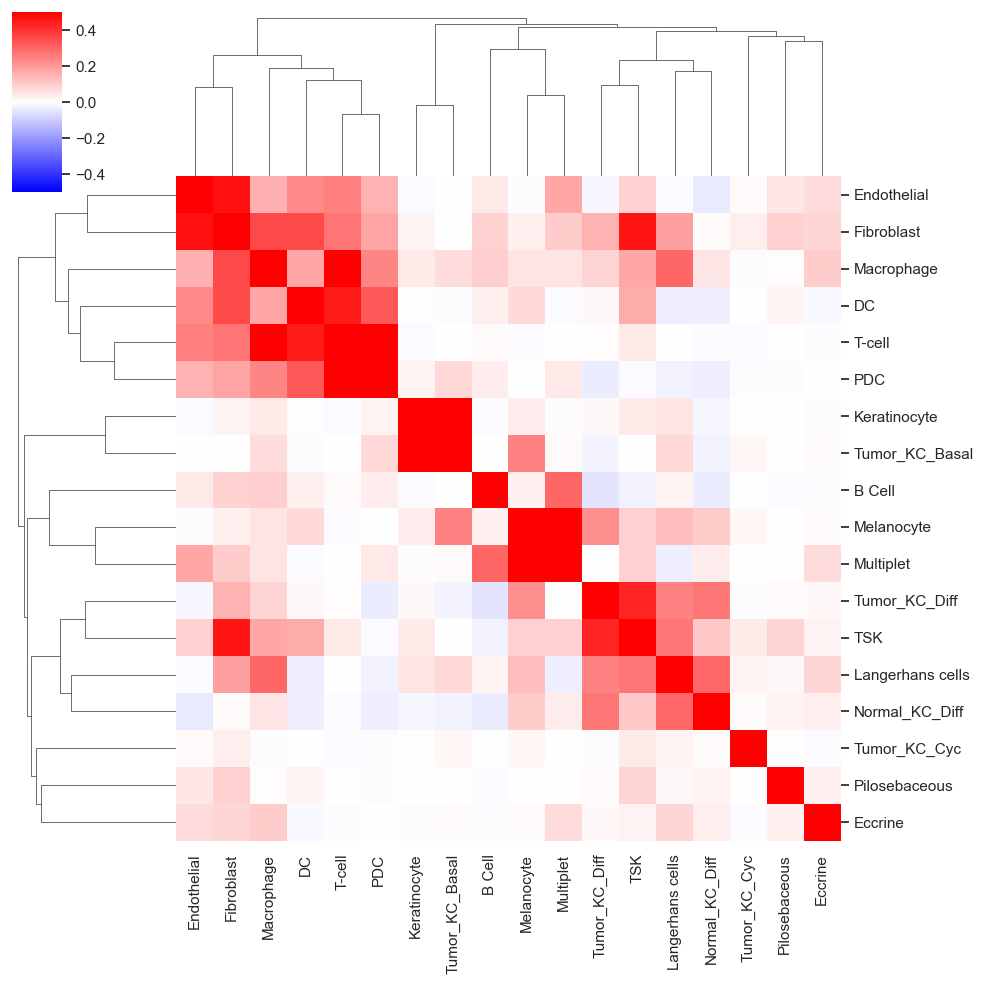

In [8]:
# --- Plotting ---
sns.set(rc={'figure.figsize': (20, 4)}, font_scale=1.0)

# Generate and display the clustermap
g = sns.clustermap(pearson_cell_type_correlation.loc[large_proportion, large_proportion], 
                   annot=False, fmt='d', cmap='bwr', xticklabels=True, yticklabels=True, vmin=-0.5, vmax=0.5)
plt.show() # Display the plot